# This is an introduction to prediction methods
## By Russ Bramblett

## Time series forecasting is appropriate when independent variables aren’t known
ARIMA is the best time series estimator as it can handle non-stationarity 
- Autoregressive
- Integrated
- Moving Average 

In addition, the time series can also be fit to a function

In [63]:
import pandas as pd

file = "c:/Users/TheDesktop/Desktop/logChuteTemp.csv"
    
dateparser = lambda d: pd.datetime.strptime(d, '%m/%d/%Y') #for parsing the date

tsdata = pd.read_csv(file, sep = ',', index_col = 'DATE', parse_dates = ['DATE'], date_parser = dateparser)

print('This is what the data looks like: \n')
print(tsdata[0:5])

This is what the data looks like: 

            TMIN
DATE            
2012-10-17    42
2012-10-18    41
2012-10-19    45
2012-10-20    45
2012-10-21    42


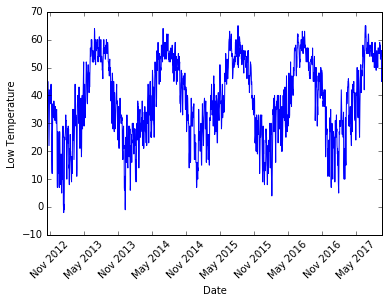

              TMIN
count  1797.000000
mean     38.308848
std      14.359596
min      -2.000000
25%      28.000000
50%      38.000000
75%      52.000000
max      65.000000


In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(tsdata)

plt.xticks(rotation = 45)
plt.ylabel('Low Temperature')
plt.xlabel('Date')

plt.show()

print(tsdata.describe())

We have to remove some data... becauce of processing limitations and to get a less erratic prediction

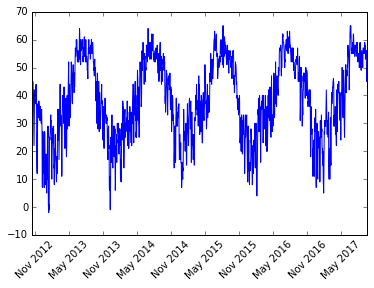

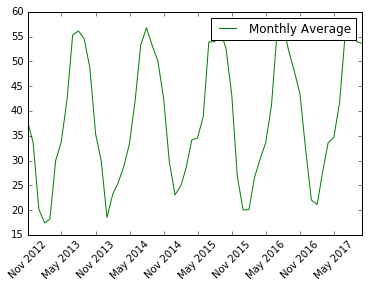

In [66]:
plt.plot(tsdata)
plt.xticks(rotation = 45)
plt.show()

tsResample = tsdata.resample("M")


plt.plot(tsResample, color = 'green')
plt.xticks(rotation = 45)
plt.legend(['Monthly Average'])
plt.show()




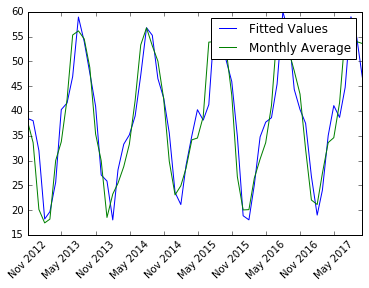

In [67]:
import statsmodels.api as sm

model = sm.tsa.ARIMA(tsResample, order=(3,0,0)).fit()  # order(AR, I, MA)

vals = model.fittedvalues # these are the values that the model produced

plt.plot(vals)
plt.plot(tsResample, color = 'green')
plt.legend(['Fitted Values', 'Monthly Average'])
plt.xticks(rotation = 45)
plt.show()


In [53]:
model.aic # this tests the fit. The lower the better the model fits the data

368.9353388006167

In [68]:
big = 1000000
warnings.filterwarnings("ignore")

# need to make a training set

tamt = int(len(tsResample)*.7)

trainingData = tsResample[:tamt]

num = 3
for i in range(num):
    for g in range(num):
        for h in range(num):
            try:
                model = sm.tsa.ARIMA(trainingData, order=(i, g, h)).fit()  
                #need to minimize this: 
                if model.aic < big:
                    big = model.aic
                    nums = [i, g, h]
                    bestRes = model
            except:
                continue
print(nums)
print(bestRes.aic)

[2, 0, 2]
240.25891643292508


# Testing the prediction

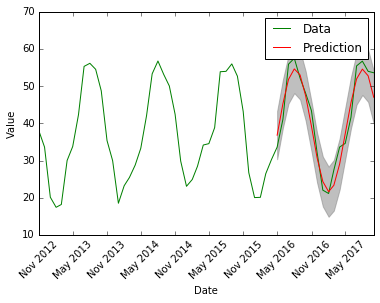

In [73]:
predictSteps = len(tsResample) - len(trainingData) #the number of steps in the future to predict

prediction, std, ci = bestRes.forecast(predictSteps) # the prediction and 95% CI

# the prediction doesn't come with x values... have to make them
preDates  = [date for date in tsResample.index[len(trainingData):]]

ciu = []
cil = []
for row in ci:
    ciu.append(row[1]) # confidence interval - upper
    cil.append(row[0]) # confidence interval - lower

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(tsResample, color = 'green', label = 'Data')
plt.plot(preDates, prediction, 'r', label='Prediction' )
plt.fill_between(preDates, ciu, cil, color = 'gray', alpha = 0.5)
plt.xlabel('Date')
plt.ylabel('Value')

plt.legend()
plt.xticks(rotation = 45)

plt.show()

# Using the validated method to forecast

[2, 1, 2]
344.108404551652


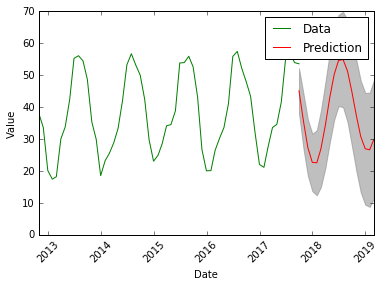

In [76]:
big = 1000000
warnings.filterwarnings("ignore")

# need to make a training set

num = 3
for i in range(num):
    for g in range(num):
        for h in range(num):
            try:
                model = sm.tsa.ARIMA(tsResample, order=(i, g, h)).fit()  
                #need to minimize this: 
                if model.aic < big:
                    big = model.aic
                    nums = [i, g, h]
                    bestRes = model
            except:
                continue
print(nums)
print(bestRes.aic)

predictSteps = len(tsResample) - len(trainingData) #the number of steps in the future to predict

prediction, std, ci = bestRes.forecast(predictSteps) # the prediction and 95% CI

# the prediction doesn't come with x values... have to make them. This time we're being a bit fancy
preDates  = pd.date_range(str(tsResample.index[-1]), periods=predictSteps, freq='M')

ciu = []
cil = []
for row in ci:
    ciu.append(row[1]) # confidence interval - upper
    cil.append(row[0]) # confidence interval - lower

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(tsResample, color = 'green', label = 'Data')
plt.plot(preDates, prediction, 'r', label='Prediction' )
plt.fill_between(preDates, ciu, cil, color = 'gray', alpha = 0.5)
plt.xlabel('Date')
plt.ylabel('Value')

plt.legend()
plt.xticks(rotation = 45)

plt.show()

# The end